In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random
import pickle

c:\Users\DryLab\anaconda3\envs\medt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset and Dataloader Check

In [ ]:
################################################################################################################
# Dataset class for mimic
#
#
################################################################################################################
class MimicTrajectoryDataset(Dataset):
    def __init__(self, dataset_path, context_len, rtg_scale, norm=False):

        self.context_len = context_len        

        # load dataset
        with open(dataset_path, 'rb') as f:
            self.trajectories = pickle.load(f)
        
        # calculate min len of traj, state mean and variance
        # and returns_to_go for all traj
        min_len = 10**6
        states = []
        for traj in self.trajectories:
            traj_len = traj['dem_observations'].shape[0]
            min_len = min(min_len, traj_len)
            states.append(traj['dem_observations'])
            # calculate returns to go and rescale them
            traj['returns_to_go'] = discount_cumsum(traj['rewards'], 0.95) / rtg_scale

        # used for input normalization
        states = np.concatenate(states, axis=0)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        # normalize states
        if norm is True:
            for traj in self.trajectories:
                traj['dem_observations'] = (traj['dem_observations'] - self.state_mean) / self.state_std

        for i in range(len(self.trajectories)):
            self.trajectories[i]['acuities'] = np.concatenate((self.trajectories[i]['acuities'][1:,:], np.reshape((self.trajectories[i]['acuities'][-1,:]), (1,10))), axis=0) #reforumulate as acuity score of next time step


    def get_state_stats(self):
        return self.state_mean, self.state_std

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = traj['dem_observations'].shape[0]

        if traj_len >= self.context_len:
            # sample random index to slice trajectory
            si = random.randint(0, traj_len - self.context_len)

            states = torch.from_numpy(traj['dem_observations'][si : si + self.context_len])
            actions = torch.from_numpy(traj['actions'][si : si + self.context_len])
            returns_to_go = torch.from_numpy(traj['returns_to_go'][si : si + self.context_len])
            timesteps = torch.arange(start=si, end=si+self.context_len, step=1)

            saps = torch.from_numpy(traj['acuities'][si : si + self.context_len,2])

            div_saps = torch.from_numpy(traj['acuities'][si : si + self.context_len,3:])

            # all ones since no padding
            traj_mask = torch.ones(self.context_len, dtype=torch.long)

            

        else:
            padding_len = self.context_len - traj_len

            # padding with zeros
            states = torch.from_numpy(traj['dem_observations'])
            states = torch.cat([states,
                                torch.zeros(([padding_len] + list(states.shape[1:])),
                                dtype=states.dtype)], 
                               dim=0)
            
            actions = torch.from_numpy(traj['actions'])
            actions = torch.cat([actions,
                                torch.zeros(([padding_len] + list(actions.shape[1:])),
                                dtype=actions.dtype)], 
                               dim=0)

            returns_to_go = torch.from_numpy(traj['returns_to_go'])
            returns_to_go = torch.cat([returns_to_go,
                                torch.zeros(([padding_len] + list(returns_to_go.shape[1:])),
                                dtype=returns_to_go.dtype)], 
                               dim=0)
            
            timesteps = torch.arange(start=0, end=self.context_len, step=1)

            traj_mask = torch.cat([torch.ones(traj_len, dtype=torch.long), 
                                   torch.zeros(padding_len, dtype=torch.long)], 
                                  dim=0)
            
            saps = torch.from_numpy(traj['acuities'][:,2])
            saps = torch.cat([saps,
                                torch.zeros(([padding_len] + list(saps.shape[1:])),
                                dtype=saps.dtype)], 
                               dim=0)
            
            div_saps = torch.from_numpy(traj['acuities'][:,3:])
            div_saps = torch.cat([div_saps,
                                torch.zeros(([padding_len] + list(div_saps.shape[1:])),
                                dtype=div_saps.dtype)], 
                               dim=0)            


        return  states, actions, returns_to_go, timesteps, saps, div_saps, traj_len


################################################################################################################
# Discounting
#
#
################################################################################################################
def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
    return disc_cumsum

In [5]:
datadir = './data'

In [7]:
CONTEXT_LENGTH = 20
RTG_SCALE = 1

# Load dataset
train_path = os.path.join(datadir, 'train_Phys45.pickle')
eval_path = os.path.join(datadir, 'val_Phys45.pickle')
test_path = os.path.join(datadir, 'test_Phys45.pickle')

train_dataset = MimicTrajectoryDataset(train_path, CONTEXT_LENGTH, RTG_SCALE)
eval_dataset = MimicTrajectoryDataset(eval_path, CONTEXT_LENGTH, RTG_SCALE)
test_dataset = MimicTrajectoryDataset(test_path, CONTEXT_LENGTH, RTG_SCALE)

In [8]:
len(train_dataset)

5506

In [9]:
states, actions, returns_to_go, timesteps, saps, div_saps, traj_len = next(iter(test_dataset))

In [10]:
# Print all shapes
print('states:', states.shape)
print('actions:', actions.shape)
print('returns_to_go:', returns_to_go.shape)
print('timesteps:', timesteps.shape)
print('saps:', saps.shape)
print('div_saps:', div_saps.shape)
print('traj_len:', traj_len)

# Print first trajectory
print('states:', states[0])
print('actions:', actions)
print('returns_to_go:', returns_to_go)
print('timesteps:', timesteps)
print('saps:', saps)
print('div_saps:', div_saps[0])
print('traj_len:', traj_len)

states: torch.Size([20, 45])
actions: torch.Size([20])
returns_to_go: torch.Size([20])
timesteps: torch.Size([20])
saps: torch.Size([20])
div_saps: torch.Size([20, 7])
traj_len: 20
states: tensor([8.0000e+00, 9.9429e+01, 1.4858e+02, 1.0014e+02, 7.5917e+01, 2.0667e+01,
        3.7400e+01, 5.0000e+01, 2.7000e+00, 1.3000e+02, 9.5000e+01, 0.0000e+00,
        1.5000e+00, 8.4000e+00, 8.9000e+00, 2.7000e+00, 8.9000e+01, 2.8000e+01,
        1.3800e+01, 7.4730e+00, 2.4915e+04, 3.0500e+01, 3.6000e+00, 1.6300e+01,
        2.7543e+02, 1.0000e+00, 6.6918e-01, 4.9830e+02, 1.6000e+01, 9.8000e+01,
        1.1490e+02, 5.0200e+00, 2.1000e+01, 1.9000e+01, 2.3000e+00, 1.2000e+00,
        1.1751e+03, 1.6000e+01, 9.1226e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 7.2000e+01, 5.4300e+01])
actions: tensor([10, 10, 14, 10, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,
         5,  5])
returns_to_go: tensor([-0.3774, -0.3972, -0.4181, -0.4401, -0.4633, -0.4877, -0.5133, -0.5404,
     

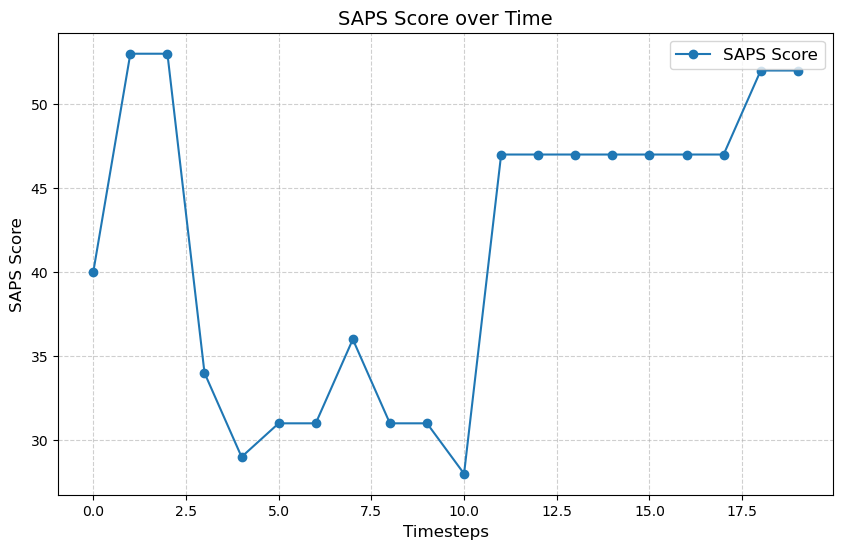

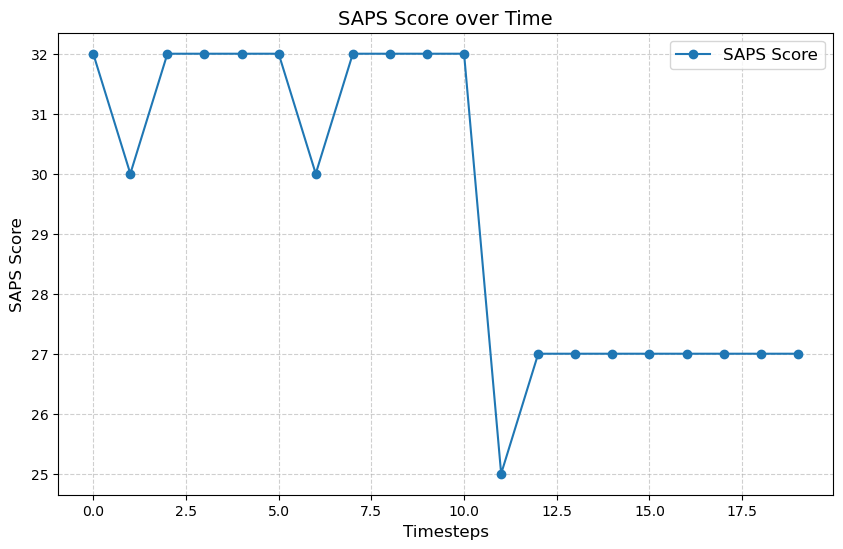

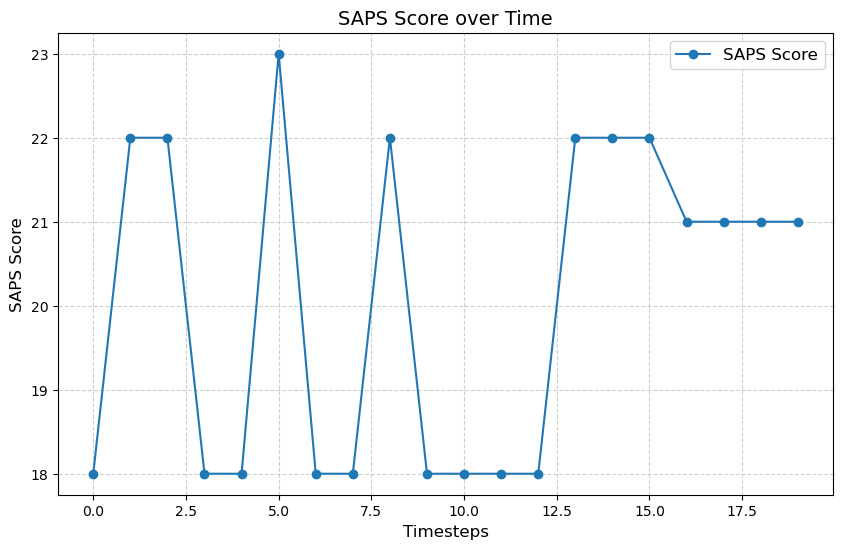

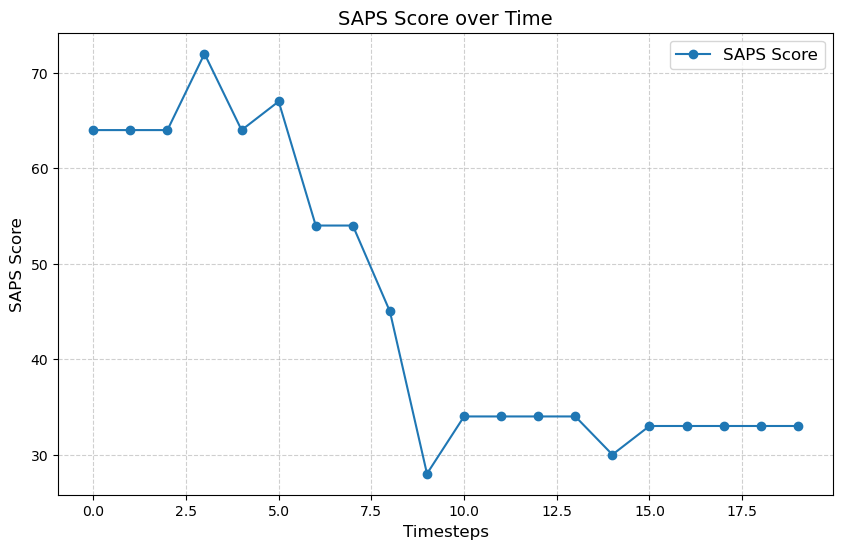

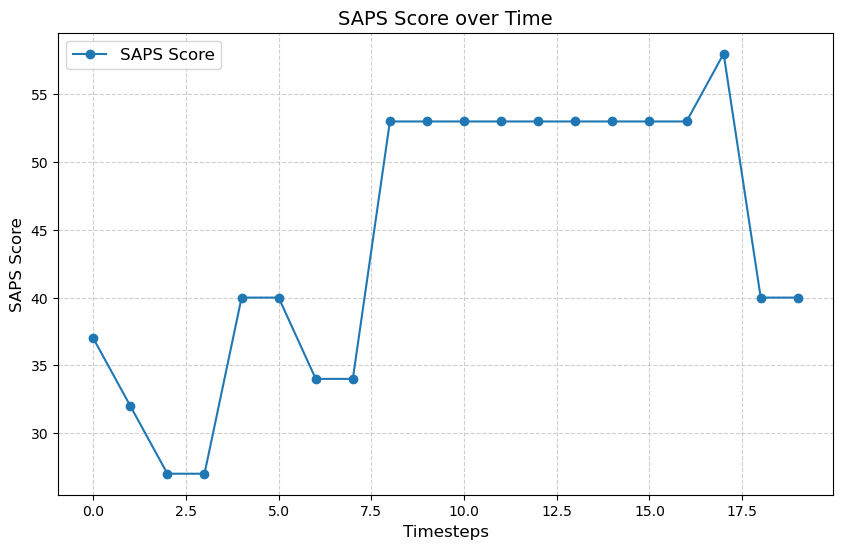

In [11]:
# Initialize lists to store data for the first 5 patients
all_states, all_actions, all_returns_to_go, all_timesteps, all_saps, all_div_saps, all_traj_len = [], [], [], [], [], [], []

# Iterate over the dataset to collect data for 5 patients
for i, data in enumerate(test_dataset):
    if i >= 5:  # Stop after collecting 5 patients
        break
    
    # Unpack data for the current patient
    states, actions, returns_to_go, timesteps, saps, div_saps, traj_len = data
    
    # Append patient data to respective lists
    all_states.append(states)
    all_actions.append(actions)
    all_returns_to_go.append(returns_to_go)
    all_timesteps.append(timesteps)
    all_saps.append(saps)
    all_div_saps.append(div_saps)
    all_traj_len.append(traj_len)

for i in range(5):  # Iterate through the first 5 patients
    plt.figure(figsize=(10, 6))
    plt.plot(all_timesteps[i], all_saps[i], marker='o', label='SAPS Score')
    plt.title('SAPS Score over Time', fontsize=14)
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('SAPS Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

## Rewards to go Gamma comparison

In [14]:
CONTEXT_LENGTH = 20
RTG_SCALE = 1

# Load dataset
train_path = os.path.join(datadir, 'train_Phys45.pickle')
eval_path = os.path.join(datadir, 'val_Phys45.pickle')
test_path = os.path.join(datadir, 'test_Phys45.pickle')

train_dataset = MimicTrajectoryDataset(train_path, CONTEXT_LENGTH, RTG_SCALE)
eval_dataset = MimicTrajectoryDataset(eval_path, CONTEXT_LENGTH, RTG_SCALE)
test_dataset = MimicTrajectoryDataset(test_path, CONTEXT_LENGTH, RTG_SCALE)

states, actions, returns_to_go, timesteps, saps, div_saps, traj_len = next(iter(test_dataset))

print('returns_to_go with gamma = 1:', returns_to_go)

returns_to_go with gamma = 1: tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])


In [17]:
CONTEXT_LENGTH = 20
RTG_SCALE = 1

# Load dataset
train_path = os.path.join(datadir, 'train_Phys45.pickle')
eval_path = os.path.join(datadir, 'val_Phys45.pickle')
test_path = os.path.join(datadir, 'test_Phys45.pickle')

train_dataset = MimicTrajectoryDataset(train_path, CONTEXT_LENGTH, RTG_SCALE)
eval_dataset = MimicTrajectoryDataset(eval_path, CONTEXT_LENGTH, RTG_SCALE)
test_dataset = MimicTrajectoryDataset(test_path, CONTEXT_LENGTH, RTG_SCALE)

states, actions, returns_to_go, timesteps, saps, div_saps, traj_len = next(iter(test_dataset))

print('returns_to_go with gamma = 0.95:', returns_to_go)

returns_to_go with gamma = 0.95: tensor([-0.3774, -0.3972, -0.4181, -0.4401, -0.4633, -0.4877, -0.5133, -0.5404,
        -0.5688, -0.5987, -0.6302, -0.6634, -0.6983, -0.7351, -0.7738, -0.8145,
        -0.8574, -0.9025, -0.9500, -1.0000])


# Load graph

### MIMIC

In [266]:
data = pd.read_csv(r"C:\Users\DryLab\Desktop\MeDT-main\medDT\logs\MeDTv1_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0\out.csv", index_col=0)

In [267]:
data.head()

,epoch,train_loss,val_loss,mean_train_accuracy,mean_val_accuracy
0,0,0.669368,0.372771,tensor(0.8950),tensor(0.8709)
1,1,0.355584,0.292856,tensor(0.9025),tensor(0.8996)
2,2,0.299298,0.262438,tensor(0.8825),tensor(0.9085)
3,3,0.268939,0.250043,tensor(0.9000),tensor(0.9144)
4,4,0.250272,0.238530,tensor(0.9400),tensor(0.9184)


In [268]:
# Clean 'tensor()' entries and convert to float
data['mean_train_accuracy'] = data['mean_train_accuracy'].str.extract(r'([\d.]+)').astype(float)
data['mean_val_accuracy'] = data['mean_val_accuracy'].str.extract(r'([\d.]+)').astype(float)

In [270]:
# Extract columns
epochs = data['epoch']
train_loss = data['train_loss']
val_loss = data['val_loss']
train_accuracy = data['mean_train_accuracy']
val_accuracy = data['mean_val_accuracy']

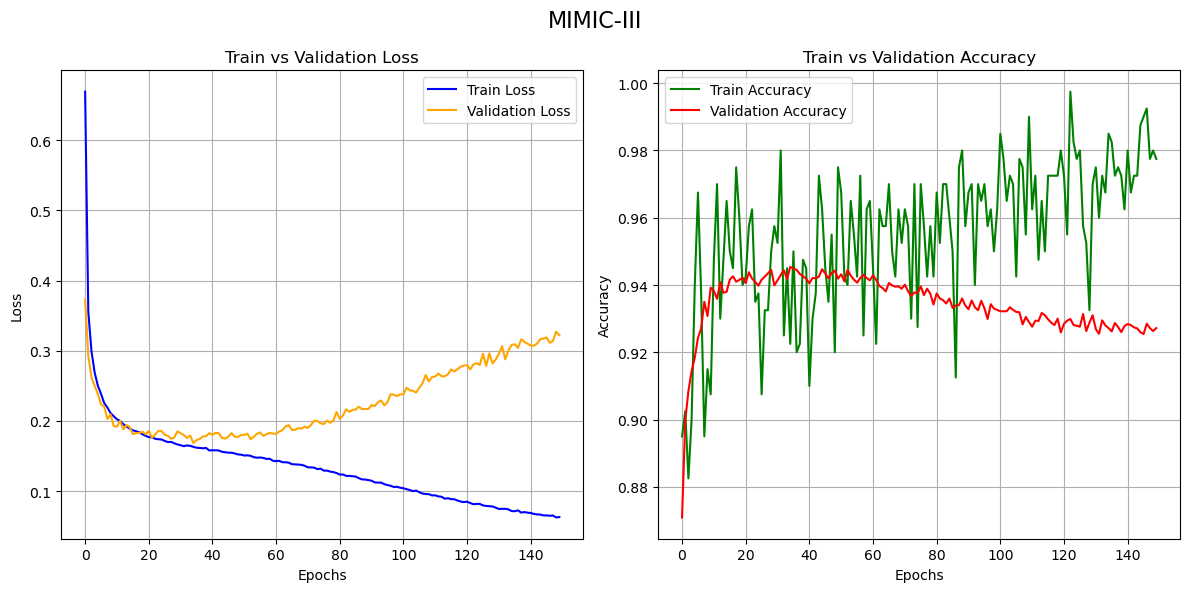

In [271]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.suptitle('MIMIC-III', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='green')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### CGRD

In [272]:
data = pd.read_csv(r"C:\Users\DryLab\Desktop\MeDT-main\cgrd_medDT\logs\MeDTv1_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0\out.csv", index_col=0)

In [273]:
# Clean 'tensor()' entries and convert to float
data['mean_train_accuracy'] = data['mean_train_accuracy'].str.extract(r'([\d.]+)').astype(float)
data['mean_val_accuracy'] = data['mean_val_accuracy'].str.extract(r'([\d.]+)').astype(float)

In [274]:
# Extract columns
epochs = data['epoch']
train_loss = data['train_loss']
val_loss = data['val_loss']
train_accuracy = data['mean_train_accuracy']
val_accuracy = data['mean_val_accuracy']

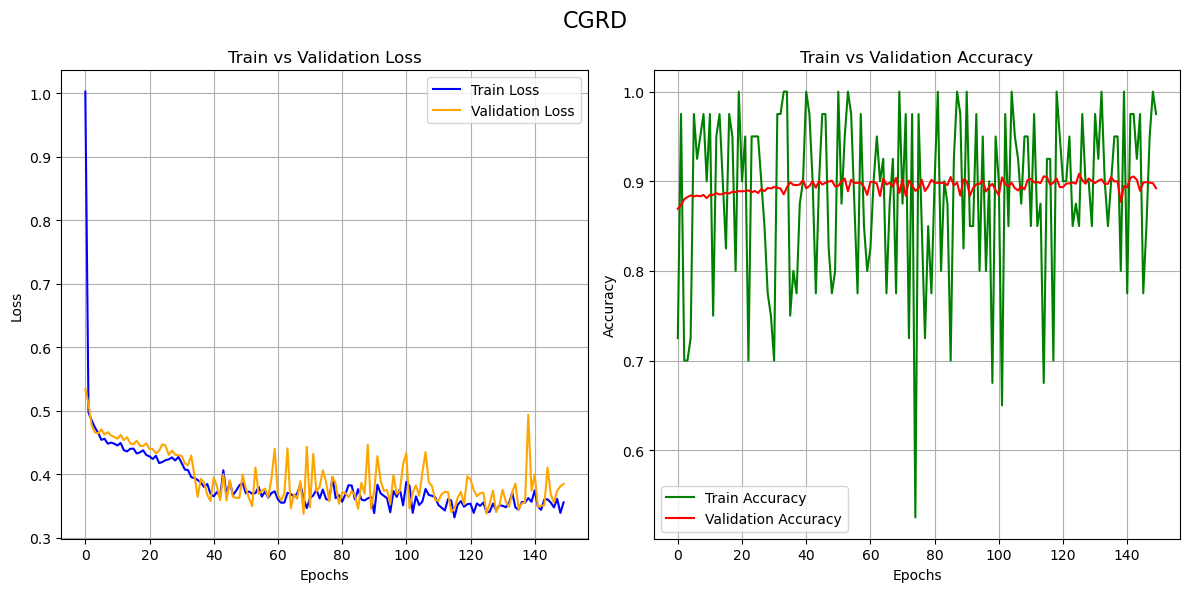

In [275]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.suptitle('CGRD', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='green')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

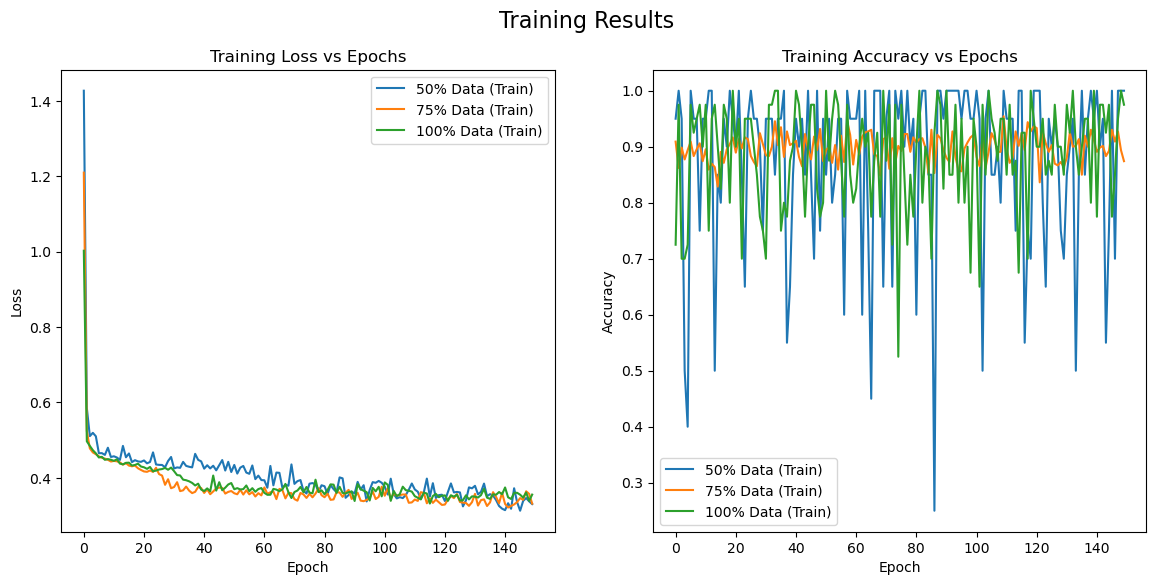

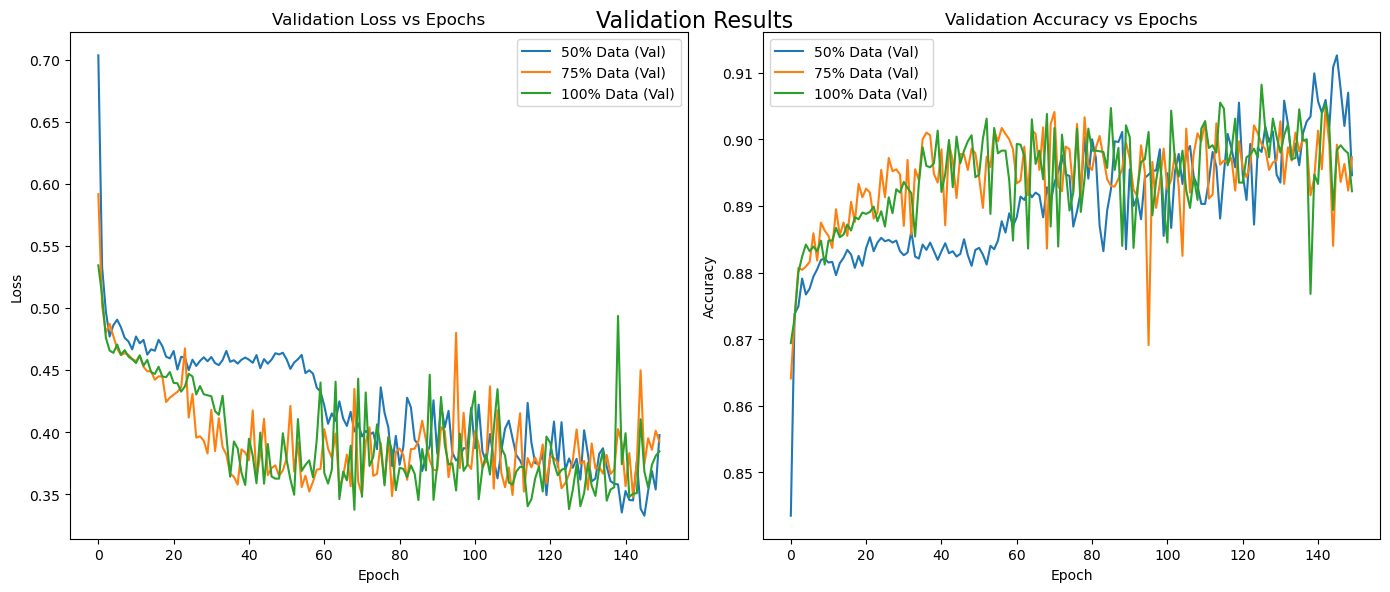

In [293]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths for the results
files = {
    "50% Data": "C:/Users/DryLab/Desktop/MeDT-main/cgrd_medDT/logs/MeDTv1_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0_P50/out.csv",
    "75% Data": "C:/Users/DryLab/Desktop/MeDT-main/cgrd_medDT/logs/MeDTv1_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0_P75/out.csv",
    "100% Data": "C:/Users/DryLab/Desktop/MeDT-main/cgrd_medDT/logs/MeDTv1_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0/out.csv",
}

# Initialize training plot
fig_train, axes_train = plt.subplots(1, 2, figsize=(14, 6))
axes_train[0].set_title("Training Loss vs Epochs")
axes_train[0].set_xlabel("Epoch")
axes_train[0].set_ylabel("Loss")
axes_train[1].set_title("Training Accuracy vs Epochs")
axes_train[1].set_xlabel("Epoch")
axes_train[1].set_ylabel("Accuracy")

# Initialize validation plot
fig_val, axes_val = plt.subplots(1, 2, figsize=(14, 6))
axes_val[0].set_title("Validation Loss vs Epochs")
axes_val[0].set_xlabel("Epoch")
axes_val[0].set_ylabel("Loss")
axes_val[1].set_title("Validation Accuracy vs Epochs")
axes_val[1].set_xlabel("Epoch")
axes_val[1].set_ylabel("Accuracy")

# Iterate over the files and plot
for label, file_path in files.items():
    # Load the CSV file
    data = pd.read_csv(file_path)
    # Ensure the CSV has the necessary columns
    epochs = data['epoch']
    
    # Plot training loss and accuracy
    axes_train[0].plot(epochs, data['train_loss'], label=f"{label} (Train)")
    axes_train[1].plot(epochs, data['mean_train_accuracy'].str.extract(r'([\d.]+)').astype(float), label=f"{label} (Train)")
    
    # Plot validation loss and accuracy
    axes_val[0].plot(epochs, data['val_loss'], label=f"{label} (Val)")
    axes_val[1].plot(epochs, data['mean_val_accuracy'].str.extract(r'([\d.]+)').astype(float), label=f"{label} (Val)")

# Add legends
axes_train[0].legend()
axes_train[1].legend()
axes_val[0].legend()
axes_val[1].legend()

# Show the plots
plt.tight_layout()

fig_train.suptitle("Training Results", fontsize=16)
fig_val.suptitle("Validation Results", fontsize=16)

plt.show()


### MIMIC State Predictor

In [276]:
data = pd.read_csv(r"C:\Users\DryLab\Desktop\MeDT-main\mimic_medDT\logs\SP_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0\out.csv", index_col=0)

In [277]:
# Extract columns
epochs = data['epoch']
train_loss = data['train_loss']
val_loss = data['val_loss']

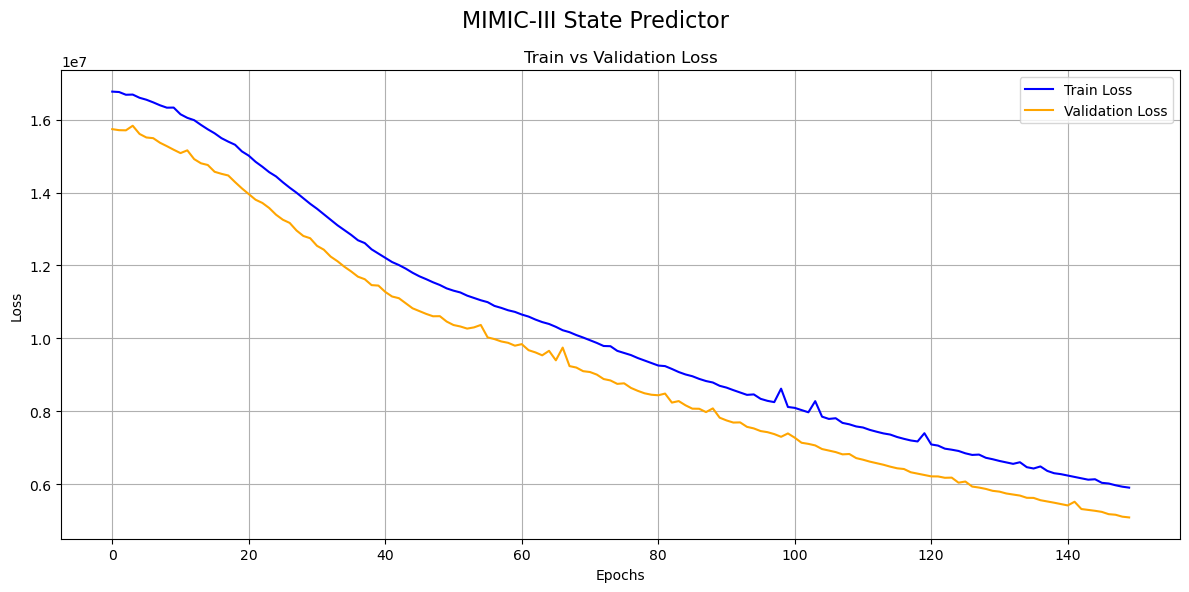

In [278]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.suptitle('MIMIC-III State Predictor', fontsize=16)

plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

### CGRD State Predictor

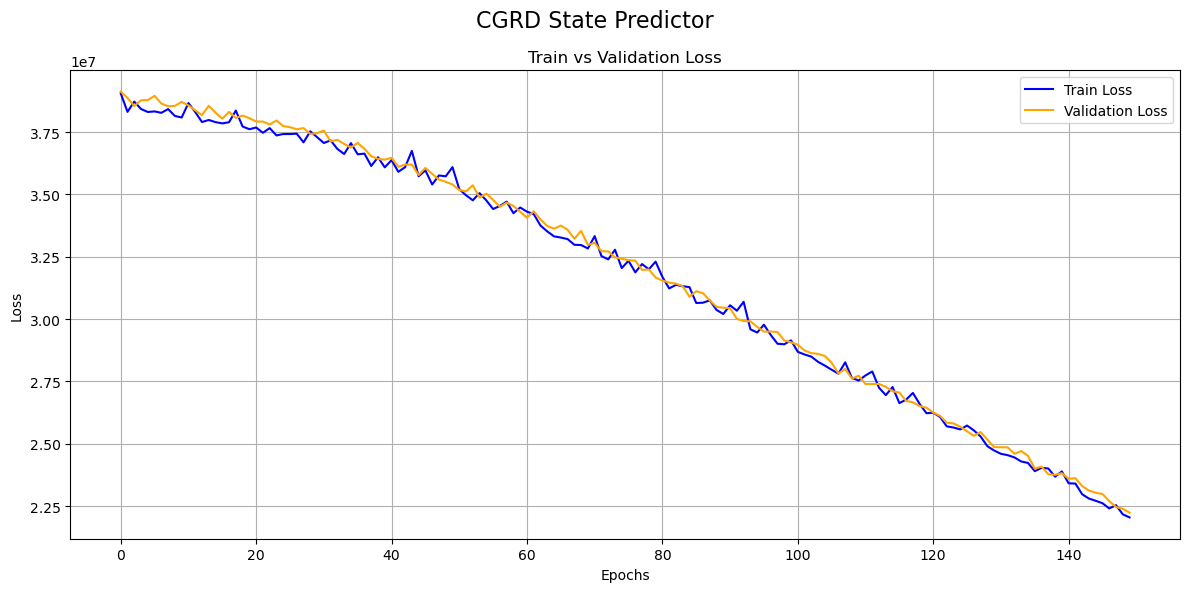

In [19]:
data = pd.read_csv(r"C:\Users\DryLab\Desktop\MeDT-main\cgrd_medDT\logs\SP_ID0_nLayer6_nHead8_nEmb128_LR0.0006_BS64_SEED0\out.csv", index_col=0)

# Extract columns
epochs = data['epoch']
train_loss = data['train_loss']
val_loss = data['val_loss']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.suptitle('CGRD State Predictor', fontsize=16)

plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

In [198]:
# # Data
# x = [50, 75, 100]  # % of training data
# medt_means = [47.03, 47.03, 47.03]  # Mean Estimated SAPS for MeDT
# dt_means = [47.4, 45.2, 40.5]    # Mean Estimated SAPS for DT

# # Standard deviations (or confidence intervals) to create shaded regions
# medt_std = [0.04, 0.04, 0.04]
# dt_std = [0.6, 0.7, 0.03]

# # Convert to numpy arrays for easier computation
# x = np.array(x)
# medt_means = np.array(medt_means)
# dt_means = np.array(dt_means)
# medt_std = np.array(medt_std)
# dt_std = np.array(dt_std)

# # Create the plot
# plt.figure(figsize=(8, 6))

# # Plot MeDT with shaded region
# plt.plot(x, medt_means, label='MeDT', color='tab:blue', linestyle='-', marker='o')
# plt.fill_between(x, medt_means - medt_std, medt_means + medt_std, color='tab:blue', alpha=0.2)

# # Plot DT with shaded region
# plt.plot(x, dt_means, label='DT', color='tab:orange', linestyle='-', marker='x')
# plt.fill_between(x, dt_means - dt_std, dt_means + dt_std, color='tab:orange', alpha=0.2)

# # Add labels, legend, and grid
# plt.xlabel('% of training data', fontsize=12)
# plt.ylabel('<-- Estimated SAPS', fontsize=12)
# plt.legend(title='Policy', fontsize=10, title_fontsize=11)
# plt.grid(False)

# # Adjust axes limits (optional for better view)
# plt.xlim(45, 105)  # Add small padding
# plt.ylim(39.5, 48.5)

# # Show the plot
# plt.tight_layout()
# plt.show()


### Policy Distribution Test Set

In [89]:
states, actions, returns_to_go, timesteps, saps, div_saps, traj_len = next(iter(test_dataset))

print('actions:', actions)

actions: tensor([10, 10, 14, 10, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,
         5,  5])


In [118]:
# Initialize an empty list to store actions
all_actions = []

# Iterate through the dataset
for states, actions, returns_to_go, timesteps, saps, div_saps, traj_len in test_dataset:
    # Append actions to the list
    all_actions.append(actions)

# Convert the list of actions into a numpy array
actions_array = np.concatenate(all_actions, axis=0)

# Now `actions_array` contains all the actions from the test dataset
actions_array.shape

(23720,)

In [192]:
np.unique(actions_array)

array([ 0,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24], dtype=int64)

In [191]:
medt_actions = np.load("C:/Users/DryLab/Desktop/MeDT-main/data/actions.npy", allow_pickle=True)
medt_actions = medt_actions.reshape(-1)
medt_actions.shape

(23720,)

In [190]:
np.unique(medt_actions)

array([ 0,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24])

c:\Users\DryLab\anaconda3\envs\medt\lib\site-packages\ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\DryLab\anaconda3\envs\medt\lib\site-packages\ipykernel_launcher.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\DryLab\anaconda3\envs\medt\lib\site-packages\ipykernel_launcher.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


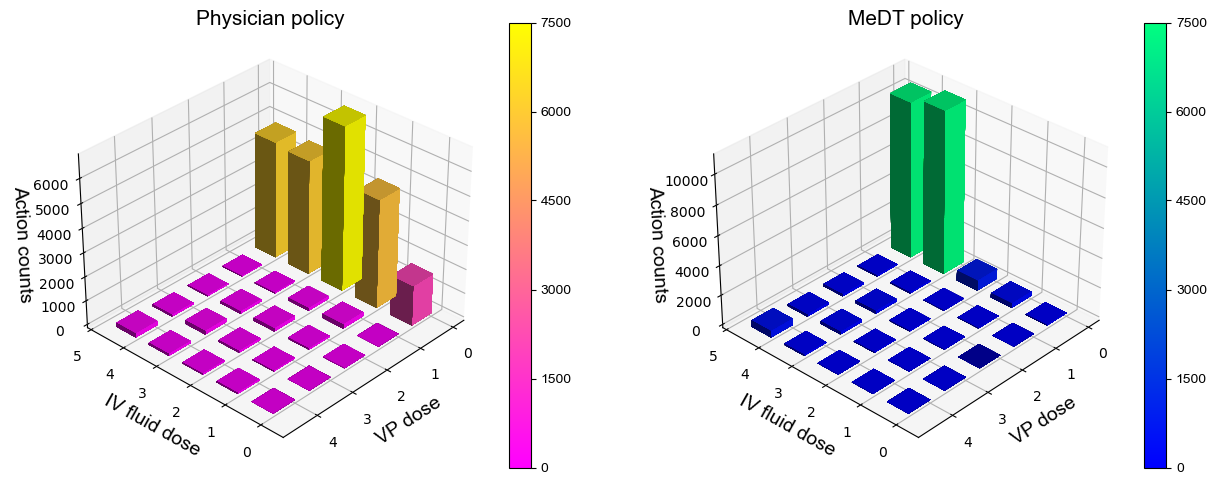

In [195]:
figures = []
ncv = 1

fig = plt.figure(figsize=(20, 5), facecolor='w')
plt.subplots_adjust(left=0.0, right=0.9, top=0.9, bottom=0.01)

ax = fig.add_subplot(131, projection='3d')
phys_actions = actions_array

inv_action_map = {}
count = 0
for i in range(5):
    for j in range(5):
        inv_action_map[count] = [i, j]
        count += 1

phys_actions_tuple = [None for i in range(len(phys_actions))]

for i in range(len(phys_actions)):
    phys_actions_tuple[i] = inv_action_map[phys_actions[i]]

phys_actions_tuple = np.array(phys_actions_tuple)

phys_actions_iv = phys_actions_tuple[:, 0]
phys_actions_vaso = phys_actions_tuple[:, 1]
hist, x_edges, y_edges = np.histogram2d(phys_actions_iv, phys_actions_vaso, bins=5)

x_edges = np.arange(-0.5, 5)
y_edges = np.arange(-0.5, 5)

Z = hist.reshape(25)
z_sun = sum(Z)
height = np.zeros_like(Z)
xx, yy = np.meshgrid(x_edges, y_edges)  # 网格化坐标
X, Y = xx.ravel(), yy.ravel()

width = depth = 0.6  # 柱子的长和宽

for i in range(0, 5):
    for j in range(0, 5):
        z = hist[i][j]  # 该柱的高
        norm = plt.Normalize(0, 0.25)
        norm_values = norm(z / z_sun)
        map_vir = cm.get_cmap(name='spring')
        colors = map_vir(norm_values)
        sc1 = ax.bar3d(j, i, height, width, depth, z, color=colors)

font1 = {'family': 'Arial', 'weight': 'normal'}

ax.set_xlabel('VP dose', fontsize=14, fontname="Arial")
ax.set_ylabel('IV fluid dose', fontsize=14, fontname="Arial")
ax.set_zlabel('Action counts', fontsize=14, fontname="Arial")
ax.set_title("Physician policy", fontsize=15, fontname="Arial")

sm = cm.ScalarMappable(cmap=map_vir, norm=norm)  # norm设置最大最小值
sm.set_array([])
#cb = plt.colorbar(sm)
cb = plt.colorbar(sm, ax=ax)
cb.ax.tick_params(labelsize=10)  # 设置色标刻度字体大小。
cb.ax.set_yticklabels([0, 1500, 3000, 4500, 6000, 7500], fontname="Arial")

ax.set_ylim(5, -0.5)
ax.view_init(32, 43)

# =========================MeDT Policy===================================================================
ax3 = fig.add_subplot(132, projection='3d')

MeDT_actions = medt_actions
MeDT_actions_tuple = [None for i in range(len(MeDT_actions))]

for i in range(len(MeDT_actions)):
    MeDT_actions_tuple[i] = inv_action_map[MeDT_actions[i]]
    
MeDT_actions_tuple = np.array(MeDT_actions_tuple)
MeDT_actions_iv = MeDT_actions_tuple[:, 0]
MeDT_actions_vaso = MeDT_actions_tuple[:, 1]

MeDT_hist, x_edges, y_edges = np.histogram2d(MeDT_actions_iv, MeDT_actions_vaso, bins=5)

x_edges = np.arange(-0.5, 5)
y_edges = np.arange(-0.5, 5)
Z = hist.reshape(25)
z_sun = sum(Z)

height = np.zeros_like(Z)
xx, yy = np.meshgrid(x_edges, y_edges)  # 网格化坐标
X, Y = xx.ravel(), yy.ravel()

for i in range(0, 5):
    for j in range(0, 5):
        z = MeDT_hist[i][j]  # 该柱的高
        norm = plt.Normalize(0, 0.25)
        norm_values = norm(z / z_sun)
        map_vir = cm.get_cmap(name='winter')
        colors = map_vir(norm_values)
        sc2 = ax3.bar3d(j, i, height, width, depth, z, color=colors)
ax3.set_xlabel('VP dose', fontsize=14, fontname="Arial")
ax3.set_ylabel('IV fluid dose', fontsize=14, fontname="Arial")
ax3.set_zlabel('Action counts', fontsize=14, fontname="Arial")
ax3.set_title("MeDT policy", fontsize=15, fontname="Arial")
sm3 = cm.ScalarMappable(cmap=map_vir, norm=norm)  # norm设置最大最小值
sm3.set_array([])

#cb3 = plt.colorbar(sm3)
cb3 = plt.colorbar(sm3, ax=ax3)
cb3.ax.tick_params(labelsize=10)  # 设置色标刻度字体大小。
cb3.ax.set_yticklabels([0, 1500, 3000, 4500, 6000, 7500], fontname="Arial")
ax3.set_ylim(5, -0.5)
ax3.view_init(32, 43)

# Uncomment below code to plot the WD3QNE policy

# =========================WD3QNE===================================================================
# ax2 = fig.add_subplot(133, projection='3d')
# IDDE_actions = np.load("C:/Users/DryLab/Desktop/WD3QNE_ryan/Q值/WD3QN_agent_actionsb.npy", allow_pickle=True)
# IDDE_actions_tuple = [None for i in range(len(IDDE_actions))]
# for i in range(len(IDDE_actions)):
#     IDDE_actions_tuple[i] = inv_action_map[IDDE_actions[i]]
# IDDE_actions_tuple = np.array(IDDE_actions_tuple)
# IDDE_actions_iv = IDDE_actions_tuple[:, 0]
# IDDE_actions_vaso = IDDE_actions_tuple[:, 1]
# IDDE_hist, x_edges, y_edges = np.histogram2d(IDDE_actions_iv, IDDE_actions_vaso, bins=5)
# x_edges = np.arange(-0.5, 5)
# y_edges = np.arange(-0.5, 5)
# Z = hist.reshape(25)
# z_sun = sum(Z)
# height = np.zeros_like(Z)
# xx, yy = np.meshgrid(x_edges, y_edges)  # 网格化坐标
# X, Y = xx.ravel(), yy.ravel()
# for i in range(0, 5):
#     for j in range(0, 5):
#         z = IDDE_hist[i][j]  # 该柱的高
#         norm = plt.Normalize(0, 0.25)
#         norm_values = norm(z / z_sun)
#         map_vir = cm.get_cmap(name='cool')
#         colors = map_vir(norm_values)
#         sc2 = ax2.bar3d(j, i, height, width, depth, z, color=colors)
# ax2.set_xlabel('VP dose', fontsize=14, fontname="Arial")
# ax2.set_ylabel('IV fluid dose', fontsize=14, fontname="Arial")
# ax2.set_zlabel('Action counts', fontsize=14, fontname="Arial")
# ax2.set_title("WD3QNE policy", fontsize=15, fontname="Arial")
# sm2 = cm.ScalarMappable(cmap=map_vir, norm=norm)  # norm设置最大最小值
# sm2.set_array([])
# #cb2 = plt.colorbar(sm2)
# cb2 = plt.colorbar(sm2, ax=ax2)
# cb2.ax.tick_params(labelsize=10)  # 设置色标刻度字体大小。
# cb2.ax.set_yticklabels([0, 1500, 3000, 4500, 6000, 7500], fontname="Arial")
# ax2.set_ylim(5, -0.5)
# ax2.view_init(32, 43)

figures.append(fig)
    
fig.show()

In [47]:
# 100 % of training data for 150 epochs
sapsii = 47.03+-0.04
Cardivascular= 11.17+-0.01
Respiratory= 6.63+-0.01
Neurological=7.25+-0.03
Renal= 5.90+-0.01
Hepatic= 3.81+-0.01
Haematologic= 0.06+-0.00
Other= 0.09+-0.00

In [ ]:
logits = -7.7631 + 0.0737 * sapsii + 0.9971 * np.log(sapsii + 1)
mortality = np.exp(logits) / (1 + np.exp(logits))

In [53]:
print(f"Mortality rate: {mortality * 100:.2f}%")
print(f"Survival rate: {(1 - mortality) * 100:.2f}%")

Mortality rate: 5.59%
Survival rate: 94.41%
